In [ ]:
# pip install gensim

In [1]:
import pandas as pd
import numpy as np
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from sklearn.metrics import confusion_matrix,classification_report
import nltk
nltk.download('punkt')
from nltk import word_tokenize
from nltk.corpus import stopwords
import string

nltk.download('punkt')
from nltk import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# i took a random data for performing topic modelling on it ..to show the sample of work that i am doing at UNited health group
df=pd.read_csv('topic_data.csv')

In [4]:
possible_labels = df.CATEGORY_ID.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict
df['label'] = df.CATEGORY_ID.replace(label_dict)

In [5]:
categories=df['CATEGORY_ID'].unique()

In [6]:
model_name='distilbert-base-uncased'

In [7]:
categories=pd.unique(df['CATEGORY_ID'])
groups_freq={}
for i in df.index:
  grp=df['CATEGORY_ID'][i]
  groups_freq[grp]=groups_freq.get(grp,0)+1
groups_freq=sorted(groups_freq.items(),key=lambda kv:(kv[1]),reverse=True)
groups_freq
# calculating the frequency of groups

[('CUTTING TOOLS', 5000),
 ('CAPITAL ASSEMBLY', 2000),
 ('CHEMICALS', 2000),
 ('LOGISTICS SERVICE', 1000)]

In [8]:
# NLP text tokens
def tokenize(text):
    words=word_tokenize(text)
    return words

In [9]:
# removing stopwords
stop=stopwords.words('english')
puncs=list(string.punctuation)
stop=stop+puncs
def remove_stops(words):
    cleaned=[w for w in words if not w.lower() in stop]
    return cleaned

In [10]:
# document parsing
def pos_tg(cleaned):
    pos=np.array(pos_tag(cleaned))
    return pos

def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [11]:
# lemitizing
lemmatizer=WordNetLemmatizer()

def lemmatize(pos):
    lemmatized=[]
    for w in pos:
        lemmatizedword=lemmatizer.lemmatize(w[0],get_simple_pos(w[1]))
        lemmatized.append(lemmatizedword)
    return lemmatized


In [12]:
def preprocess(text):
    words=tokenize(text)
    cleaned=remove_stops(words)
    pos=pos_tag(cleaned)
    lemmatized=lemmatize(pos)
    preprocessed=" ".join(lemmatized)
    return preprocessed

In [13]:

# data preprocessing step where some characters which are not required are removed 
# 1. special characters
# 2. digits in this use case
# 3. extra spaces
# 4. some words like block are used in lot of sentences and is surrounded by other characters ..needed to be separated
# 5 words less than  3 and greater than 20 add no meaning to data , so those are also removed
worddic={}
rows=[]
for i in df.index:
    row=df['ITEM_NAME'][i]
    row=df['ITEM_NAME'][i].lower()
    # row=re.sub(r'(\S*)([0-9]+)(\S*)'," ",row)
    # row=re.sub(r'[!@#$%`^&,.*)_(-+|}{":?\/<>]'," ",row)
    row=re.sub('[^A-Za-z0-9]+', ' ', row)
    if row.count(' ')>(len(row)-row.count(' ')-2):
    row=row.replace(' ','')
    no_list=[]
    for item in row:
        if re.search('[a-zA-Z]',item):
            no_list.append(item)
        if re.search('\d',item):
            no_list.append(' ')
            no_list.append(item)
        row=''.join(no_list)
      # row=re.sub("[A-Za-z]+", lambda ele: " " + ele[0] + " ", row)
    row=re.sub(r'(\s*)\n(\s*)'," ",row)
    row=re.sub(r'(\s*)\-(\s*)'," ",row)
    row=re.sub(r'(\s*)\=(\s*)'," ",row)
    row=re.sub(r'(\s*)\\(\s*)'," ",row)
    row=re.sub(r"(\s*)'(\s*)"," ",row)
    row=re.sub(r'block','block ',row)
    # row=re.sub(r'')
    tokens=row.split(" ")
    tokens=[t.lower() for t in tokens if len(t)>=1 and len(t)<20]
    text=" ".join(tokens)

    row=preprocess(text)
    tokens=row.split(" ")
    for j in tokens:
    worddic[j]=worddic.get(j,0)+1
    rows.append(row)

In [14]:
df['refined_text']=rows


In [15]:
# empty and null sentences are removed
df[df['refined_text'].str.contains(r'^\s*$', na=False)].head()

,Unnamed: 0,ITEM_NAME,CATEGORY_ID,label,refined_text
2094,2094,.,CHEMICALS,1,
4613,4613,.,CUTTING TOOLS,2,
4692,4692,??????,CUTTING TOOLS,2,
9118,9118,50CTCHMIRNS34MC115M1100,LOGISTICS SERVICE,3,
9327,9327,AUGERGATHERINGHDM066H-D MA,LOGISTICS SERVICE,3,


In [16]:
df_new=df.drop(df[df['refined_text'].str.contains(r'^\s*$', na=False)].index).copy()

In [17]:
df_new.head()

,Unnamed: 0,ITEM_NAME,CATEGORY_ID,label,refined_text
0,0,CALIBRACION TRANSDUCER 75 nm,CAPITAL ASSEMBLY,0,calibracion transducer 75 nm
1,1,for pusher whskey,CAPITAL ASSEMBLY,0,pusher whskey
2,2,Stat 40B Press Head Cup to Carrier from Stati...,CAPITAL ASSEMBLY,0,stat 40b press head cup carrier station k2xx t...
3,3,TRANSD. Cable (4145097103) scrw,CAPITAL ASSEMBLY,0,transd cable 4145097103 scrw
4,4,"ZT200 7,5BAR,13BAR60HZ NUMERO DE SERIE: AIF09...",CAPITAL ASSEMBLY,0,zt200 7 5bar 13bar60hz numero de serie aif0944...


In [69]:
worddic=sorted(worddic.items(), key =lambda kv:(kv[1], kv[0]),reverse=True)
worddic[0:5]

AttributeError: ignored

In [19]:
len(worddic)
# total no of unique word count

15002

In [20]:
import nltk
nltk.download('words')
englishwords=nltk.corpus.words.words() 
englishdic_short={}
nonenglishdic_short={}
for i in worddic:
    a=i[0]
    if a in englishwords:
        englishdic_short[a]=englishdic_short.get(a,0)+i[1]
    else:
        nonenglishdic_short[a]=nonenglishdic_short.get(a,0)+i[1]

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [21]:
# separating the non english and english words
print(f"Number of english words: {len(englishdic_short)}")
print(f"Number of non-english words: {len(nonenglishdic_short)}")

Number of english words: 2651
Number of non-english words: 12351


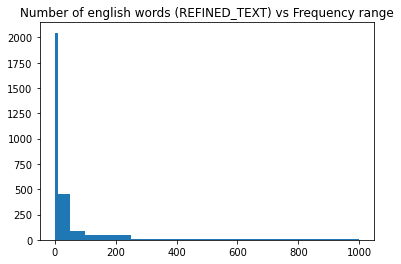

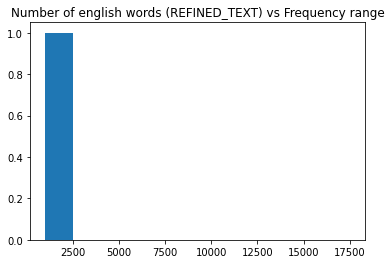

In [22]:
# Plotting the histogram for english words in short description
import matplotlib.pyplot as plt
plt.hist([ i[1] for i in englishdic_short.items()],bins=[0,10,50,100,250,500,1000]) 
plt.title('Number of english words (REFINED_TEXT) vs Frequency range')
plt.show()
plt.hist([ i[1] for i in englishdic_short.items()],bins=[1000,2500,5000,7500,10000,12500,15000,17500]) 
plt.title('Number of english words (REFINED_TEXT) vs Frequency range')
plt.show()

In [23]:
sorted_englishdic_short=sorted(englishdic_short.items(), key =lambda kv:(kv[1], kv[0]),reverse=True)

In [24]:
sorted_nonenglishdic_short=sorted(nonenglishdic_short.items(), key =lambda kv:(kv[1], kv[0]),reverse=True)

In [25]:
# Creating a dataframe of sorted english words in short description
df_english_short = pd.DataFrame.from_dict(dict(sorted_englishdic_short),orient='index') 
df_english_short.reset_index(inplace=True)
df_english_short.columns=['word','count']
df_english_short.head()

,word,count
0,de,1547
1,tool,806
2,x,701
3,insert,623
4,drill,538


In [26]:
# Creating a dataframe of sorted non - english words in short description
df_nonenglish_short = pd.DataFrame.from_dict(dict(sorted_nonenglishdic_short), orient='index') #Making the dataframe of non english words
df_nonenglish_short.reset_index(inplace=True)
df_nonenglish_short.columns=['word','count']
df_nonenglish_short.head()

,word,count
0,015,2853
1,1,1511
2,2,912
3,5,730
4,4,576


In [27]:
# Saving dataframes into csv files
df_english_short.to_csv('english_words.csv')
df_nonenglish_short.to_csv('Nonenglish_words.csv')

In [ ]:
# as i have no idea about domain of this data so i am continuing with english words with characters >2
#otherwise i would have filtered  words from non_english_words

In [28]:
df_refined_english_words=df_english_short[df_english_short['word'].str.len()>2]

In [29]:
total_words=df_refined_english_words['word'].values

In [30]:
total_words

array(['tool', 'insert', 'drill', ..., 'accept', 'absorption', 'able'],
      dtype=object)

In [31]:
import gensim
from gensim.models import CoherenceModel

In [32]:
final_desc = []                     #Filtering out and keeping only words which appear in total words
for i in df.index:
    filter_desc=[]
    des=df['refined_text'][i].split()
    for j in des:
        if j in total_words:
            filter_desc.append(j)
    final_desc.append(filter_desc)

In [33]:
final_desc=list(filter(None,final_desc))

In [34]:
dictionary_desc=gensim.corpora.Dictionary(final_desc) #Making a dictionary of all the words

In [35]:
bow_corpus_desc=[dictionary_desc.doc2bow(i) for i in final_desc] #Bag of words corpus

In [36]:
def compute_coherence_values(dictionary,corpus,texts,limit,start,step):
    coherence_values = []
    model_list = []
    for num_topics in range(start,limit,step):
        lda_model_desc=gensim.models.ldamulticore.LdaMulticore(corpus,num_topics=num_topics,id2word=dictionary,passes=15,workers=2,random_state=0)
        model_list.append(lda_model_desc)
        coherence_model_lda_sdesc=CoherenceModel(model=lda_model_desc,texts=texts,dictionary=dictionary,coherence='c_v')
        coherence_lda_desc=coherence_model_lda_sdesc.get_coherence()
        print(f'\n Coherence Score for topics={num_topics} is:', coherence_lda_desc)
        coherence_values.append(coherence_lda_desc)

    return model_list, coherence_values

In [37]:
model_list_1, coherence_values_desc = compute_coherence_values(dictionary_desc,bow_corpus_desc,final_desc,start=1,limit=17,step=3)


 Coherence Score for topics=1 is: 0.6342503189878073

 Coherence Score for topics=4 is: 0.4770663971777811

 Coherence Score for topics=7 is: 0.5436305400052807

 Coherence Score for topics=10 is: 0.54218376531075

 Coherence Score for topics=13 is: 0.5032567898952921

 Coherence Score for topics=16 is: 0.5263692771939619


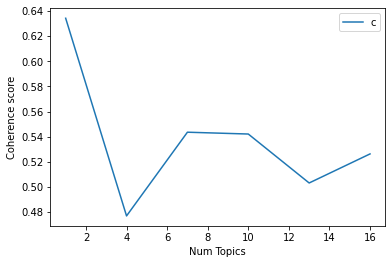

In [38]:
import matplotlib.pyplot as plt
limit = 17
start = 1
step = 3
x = range(start,limit,step)
plt.plot(x, coherence_values_desc)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc="best")
plt.show()

In [39]:
model_list_1[2]

In [40]:
lda_model_desc =model_list_1[2]
coherence_model_lda_desc=CoherenceModel(model=lda_model_desc,texts=final_desc,dictionary=dictionary_desc,coherence='c_v')
coherence_lda_desc=coherence_model_lda_desc.get_coherence()
print(f'\n Coherence Score for topics={7} is:', coherence_lda_desc)


 Coherence Score for topics=7 is: 0.5436305400052807


In [41]:
for idx,topic in lda_model_desc.print_topics(-1):
    print(f"Topic : {idx+1}")
    print(f"Words : {topic}")

Topic : 1
Words : 0.102*"drill" + 0.080*"para" + 0.032*"tool" + 0.029*"body" + 0.027*"aam" + 0.025*"shank" + 0.023*"oil" + 0.021*"con" + 0.021*"gallon" + 0.018*"rack"
Topic : 2
Words : 0.048*"tool" + 0.029*"planta" + 0.027*"type" + 0.026*"ref" + 0.020*"air" + 0.016*"freight" + 0.016*"rebuild" + 0.016*"build" + 0.015*"cable" + 0.015*"assembly"
Topic : 3
Words : 0.048*"cut" + 0.046*"mill" + 0.037*"end" + 0.031*"screw" + 0.029*"clamp" + 0.023*"unit" + 0.021*"tool" + 0.019*"diamond" + 0.018*"sleeve" + 0.015*"area"
Topic : 4
Words : 0.046*"drive" + 0.034*"type" + 0.031*"shaft" + 0.025*"gear" + 0.021*"size" + 0.016*"driver" + 0.016*"fee" + 0.014*"chemical" + 0.014*"adapter" + 0.014*"set"
Topic : 5
Words : 0.038*"drum" + 0.028*"turn" + 0.025*"case" + 0.025*"gal" + 0.021*"block" + 0.017*"coolant" + 0.016*"grind" + 0.016*"back" + 0.013*"axle" + 0.012*"line"
Topic : 6
Words : 0.043*"print" + 0.042*"serial" + 0.039*"new" + 0.034*"engrave" + 0.034*"make" + 0.026*"insert" + 0.022*"material" + 0.022

#using bigrams

In [55]:
#lda on description without threshold
bigram_desc = gensim.models.Phrases(final_desc, min_count=5) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod_desc = gensim.models.phrases.Phraser(bigram_desc)

def make_bigrams(texts):
    return [bigram_mod_desc[doc] for doc in texts]

In [56]:
final_bigram_desc = make_bigrams(final_desc)
dictionary_desc_bigram=gensim.corpora.Dictionary(final_bigram_desc) #Making a dictionary of all the words

In [57]:
bow_corpus_desc_bigram=[dictionary_desc_bigram.doc2bow(i) for i in final_bigram_desc] #Bag of words corpus

In [58]:
model_list_2, coherence_values_desc_bigram = compute_coherence_values(dictionary_desc_bigram,bow_corpus_desc_bigram,final_bigram_desc,start=1,limit=17,step=3)



 Coherence Score for topics=1 is: 0.6981300223872863

 Coherence Score for topics=4 is: 0.603268240062818

 Coherence Score for topics=7 is: 0.5851560022310812

 Coherence Score for topics=10 is: 0.5755807249296542

 Coherence Score for topics=13 is: 0.5880248063592673

 Coherence Score for topics=16 is: 0.5851618534015093


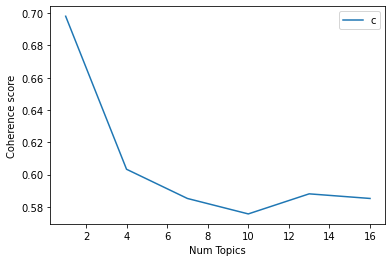

In [59]:
limit = 17
start = 1
step = 3
x = range(start,limit,step)
plt.plot(x, coherence_values_desc_bigram)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc="best")
plt.show()

In [60]:
#number of topics 4

lda_model_desc_bigram=model_list_2[1]
coherence_model_lda_desc_bigram=CoherenceModel(model=lda_model_desc_bigram,texts=final_bigram_desc,dictionary=dictionary_desc_bigram,coherence='c_v')
coherence_lda_desc_bigram=coherence_model_lda_desc_bigram.get_coherence()
print(f'\n Coherence Score for topics={4} is:', coherence_lda_desc_bigram)


 Coherence Score for topics=4 is: 0.603268240062818


In [61]:
for idx,topic in lda_model_desc_bigram.print_topics(-1):
    print(f"Topic : {idx+1}")
    print(f"Words : {topic}")

Topic : 1
Words : 0.035*"type" + 0.034*"para" + 0.024*"block" + 0.019*"end_mill" + 0.018*"ref" + 0.017*"cable" + 0.016*"carbide" + 0.015*"build" + 0.011*"con" + 0.009*"ball"
Topic : 2
Words : 0.024*"clamp" + 0.023*"drum" + 0.020*"cut" + 0.012*"set" + 0.012*"type" + 0.011*"mill" + 0.010*"chemical" + 0.009*"diamond_sleeve" + 0.008*"gal" + 0.007*"banda"
Topic : 3
Words : 0.079*"insert" + 0.041*"drill" + 0.022*"screw" + 0.018*"make_new" + 0.018*"serial" + 0.015*"material" + 0.015*"print_engrave" + 0.014*"charge" + 0.013*"print" + 0.010*"part"
Topic : 4
Words : 0.084*"tool" + 0.051*"repair" + 0.021*"drill" + 0.014*"boring_bar" + 0.014*"best_tool" + 0.012*"head" + 0.012*"body_shank" + 0.012*"cut_unit" + 0.011*"rebuild" + 0.009*"coolant"


In [62]:
#number of topics  7
lda_model_desc_bigram2=model_list_2[2]
coherence_model_lda_desc_bigram2=CoherenceModel(model=lda_model_desc_bigram2,texts=final_bigram_desc,dictionary=dictionary_desc_bigram,coherence='c_v')
coherence_lda_desc_bigram2=coherence_model_lda_desc_bigram2.get_coherence()
print(f'\n Coherence Score for topics={7} is:', coherence_lda_desc_bigram2)


 Coherence Score for topics=7 is: 0.5851560022310812


In [42]:
#with threshold
bigram_desc_thres = gensim.models.Phrases(final_desc, min_count=5,threshold=20) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod_desc_thres = gensim.models.phrases.Phraser(bigram_desc_thres)

def make_bigrams_with_threshold(texts):
    return [bigram_mod_desc_thres[doc] for doc in texts]

In [43]:
final_bigram_desc_thres = make_bigrams_with_threshold(final_desc)

In [44]:
dictionary_desc_bigram_thres = gensim.corpora.Dictionary(final_bigram_desc_thres) #Making a dictionary of all the words

In [45]:
bow_corpus_desc_bigram_thres = [dictionary_desc_bigram_thres.doc2bow(i) for i in final_bigram_desc_thres] #Bag of words corpus

In [46]:
model_list_3, coherence_values_desc_bigram_thres = compute_coherence_values(dictionary_desc_bigram_thres,bow_corpus_desc_bigram_thres,final_bigram_desc_thres,start=1,limit=17,step=3)


 Coherence Score for topics=1 is: 0.6489402322995892

 Coherence Score for topics=4 is: 0.5674087541643171

 Coherence Score for topics=7 is: 0.5878325709187642

 Coherence Score for topics=10 is: 0.5546798147520879

 Coherence Score for topics=13 is: 0.5610713120563376

 Coherence Score for topics=16 is: 0.5518936572371336


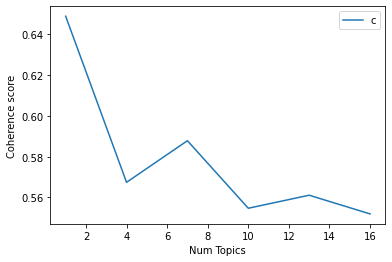

In [47]:
limit = 17
start = 1
step = 3
x = range(start,limit,step)
plt.plot(x, coherence_values_desc_bigram_thres)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc="best")
plt.show()

In [48]:
#number of topics -7

lda_model_desc_bigram_thres=model_list_3[2]
coherence_model_lda_desc_bigram_thres=CoherenceModel(model=lda_model_desc_bigram_thres,texts=final_bigram_desc_thres,dictionary=dictionary_desc_bigram_thres,coherence='c_v')
coherence_lda_desc_bigram_thres=coherence_model_lda_desc_bigram_thres.get_coherence()
print(f'\n Coherence Score for topics={7} is:', coherence_lda_desc_bigram_thres)


 Coherence Score for topics=7 is: 0.5878325709187642


In [49]:
for idx,topic in lda_model_desc_bigram_thres.print_topics(-1):
    print(f"Topic : {idx+1}")
    print(f"Words : {topic}")

Topic : 1
Words : 0.093*"para" + 0.025*"base" + 0.025*"make_new" + 0.021*"print_engrave" + 0.021*"pin" + 0.016*"carrier" + 0.016*"serial" + 0.013*"key" + 0.013*"collet" + 0.012*"master"
Topic : 2
Words : 0.045*"type" + 0.037*"tool" + 0.032*"best" + 0.028*"clamp" + 0.023*"chemical" + 0.023*"rebuild" + 0.021*"bar" + 0.020*"mill" + 0.014*"head" + 0.013*"unit"
Topic : 3
Words : 0.102*"insert" + 0.041*"charge" + 0.022*"planta" + 0.021*"material" + 0.018*"case" + 0.017*"print" + 0.015*"serial" + 0.015*"drive" + 0.015*"gear" + 0.015*"turn"
Topic : 4
Words : 0.105*"drill" + 0.026*"block" + 0.025*"ref" + 0.020*"oil" + 0.019*"build" + 0.018*"fee" + 0.015*"use" + 0.012*"part" + 0.012*"gallon" + 0.011*"case"
Topic : 5
Words : 0.037*"drum" + 0.032*"end_mill" + 0.032*"carbide" + 0.029*"con" + 0.021*"gal" + 0.019*"diamond_grit" + 0.017*"boring_bar" + 0.017*"tool" + 0.014*"flute" + 0.014*"shank"
Topic : 6
Words : 0.123*"tool" + 0.077*"repair" + 0.039*"aam" + 0.038*"screw" + 0.019*"cut_unit" + 0.017*"d

In [50]:
lda_model_desc_bigram_thres2=model_list_3[2]
coherence_model_lda_desc_bigram_thres2=CoherenceModel(model=lda_model_desc_bigram_thres2,texts=final_bigram_desc_thres,dictionary=dictionary_desc_bigram_thres,coherence='c_v')
coherence_lda_desc_bigram_thres2=coherence_model_lda_desc_bigram_thres2.get_coherence()
print(f'\n Coherence Score for topics={7} is:', coherence_lda_desc_bigram_thres2)


 Coherence Score for topics=7 is: 0.5878325709187642


In [51]:
for idx,topic in lda_model_desc_bigram_thres2.print_topics(-1):
    print(f"Topic : {idx+1}")
    print(f"Words : {topic}")

Topic : 1
Words : 0.093*"para" + 0.025*"base" + 0.025*"make_new" + 0.021*"print_engrave" + 0.021*"pin" + 0.016*"carrier" + 0.016*"serial" + 0.013*"key" + 0.013*"collet" + 0.012*"master"
Topic : 2
Words : 0.045*"type" + 0.037*"tool" + 0.032*"best" + 0.028*"clamp" + 0.023*"chemical" + 0.023*"rebuild" + 0.021*"bar" + 0.020*"mill" + 0.014*"head" + 0.013*"unit"
Topic : 3
Words : 0.102*"insert" + 0.041*"charge" + 0.022*"planta" + 0.021*"material" + 0.018*"case" + 0.017*"print" + 0.015*"serial" + 0.015*"drive" + 0.015*"gear" + 0.015*"turn"
Topic : 4
Words : 0.105*"drill" + 0.026*"block" + 0.025*"ref" + 0.020*"oil" + 0.019*"build" + 0.018*"fee" + 0.015*"use" + 0.012*"part" + 0.012*"gallon" + 0.011*"case"
Topic : 5
Words : 0.037*"drum" + 0.032*"end_mill" + 0.032*"carbide" + 0.029*"con" + 0.021*"gal" + 0.019*"diamond_grit" + 0.017*"boring_bar" + 0.017*"tool" + 0.014*"flute" + 0.014*"shank"
Topic : 6
Words : 0.123*"tool" + 0.077*"repair" + 0.039*"aam" + 0.038*"screw" + 0.019*"cut_unit" + 0.017*"d

In [52]:
# FINDING DOMINANT TOPIC
# CONSIDERING LDA MODEL FOR BIGRAMS WITHOUT THRESHOLD
def format_topic_sentences(ldamodel, corpus):
    sent_topics_df = pd.DataFrame()

    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:                    # DOMINANT TOPIC
                word_prop = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in word_prop])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index = True)
            else:
                break
    sent_topics_df.columns = ['Dominant Topic', 'Percent Contribution', 'Topic Keywords']
    return sent_topics_df

In [53]:
df_topics_desc = format_topic_sentences(ldamodel=lda_model_desc_bigram_thres, corpus=bow_corpus_desc_bigram_thres)

In [63]:
desc_texts = pd.Series(final_bigram_desc)
df_topics_desc = pd.concat([df_topics_desc, desc_texts], axis=1)
df_topics_desc.head()

,Dominant Topic,Percent Contribution,Topic Keywords,0
0,1.0,0.5714,"type, tool, best, clamp, chemical, rebuild, ba...",[transducer]
1,0.0,0.5714,"para, base, make_new, print_engrave, pin, carr...",[pusher]
2,0.0,0.5792,"para, base, make_new, print_engrave, pin, carr...","[press, head, cup, carrier, station, member_line]"
3,2.0,0.5711,"insert, charge, planta, material, case, print,...",[cable]
4,1.0,0.7855,"type, tool, best, clamp, chemical, rebuild, ba...","[numero, fan, radial]"


In [64]:
# these are the dominant topics that i got for each of topic classified
df_topics_desc.columns = ['Dominant Topic', 'Percent Contribution', 'Topic Keywords', 'description']
df_topics_desc.head()

,Dominant Topic,Percent Contribution,Topic Keywords,description
0,1.0,0.5714,"type, tool, best, clamp, chemical, rebuild, ba...",[transducer]
1,0.0,0.5714,"para, base, make_new, print_engrave, pin, carr...",[pusher]
2,0.0,0.5792,"para, base, make_new, print_engrave, pin, carr...","[press, head, cup, carrier, station, member_line]"
3,2.0,0.5711,"insert, charge, planta, material, case, print,...",[cable]
4,1.0,0.7855,"type, tool, best, clamp, chemical, rebuild, ba...","[numero, fan, radial]"


In [65]:
df_topics_desc.to_csv('Combined_Dominant_topics_desc.csv')

In [66]:
#acc to frequency
topic_freq = dict()
for i in df_topics_desc.index:
    topic_num = df_topics_desc['Dominant Topic'][i]
    if topic_num not in topic_freq:
        topic_freq[topic_num] = 0
    topic_freq[topic_num] += 1

sorted_topic_freq = sorted(topic_freq.items())

In [67]:
sorted_topic_freq

[(0.0, 947),
 (1.0, 1265),
 (2.0, 1274),
 (3.0, 1207),
 (4.0, 1241),
 (5.0, 1288),
 (6.0, 1085)]

In [ ]:
# topic modelling is used to classify words to different topics that can be used to identify issues of  various categories 
# also to find hidden issues in the data that are not seen due to large volumne of data
# even topic modelling is used in recommendation engines when we need unsupervised algorithms